Imports

In [ ]:

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np




In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
wandb.login()
import tensorflow as tf

wandb: Currently logged in as: itamar-schechter (itamars). Use `wandb login --relogin` to force relogin


Load Data

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)

batch_size = 16

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Function for find test loss

In [ ]:
def record_test_loss(net):
    total_loss = 0.0
    i = 1
    # check_images_net(net)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            total_loss += loss.item() * inputs.size(0)
            i += 1

    num_of_images = inputs.shape[0] * (i)  # batch size * num of batches
    average_loss = total_loss / num_of_images
    print(f'test: num_of_images: {num_of_images}, total loss: {total_loss}, test loss: {average_loss}')
    print(f"total loss: {total_loss}, num of batches: {i}")
    print('Average test set loss per batch: {:.4f}'.format(average_loss))
    print("Input")
    fig, axs = plt.subplots(1, inputs.shape[0], figsize=(10, 10))
    for j in range(inputs.shape[0]):
        vals = inputs[j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()
    print("Output")
    fig, axs = plt.subplots(1, inputs.shape[0], figsize=(10, 10))
    for j in range(outputs.shape[0]):
        vals = outputs[j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()
    return average_loss

Function to train the model, and evaluation his permoances while training.

In [9]:
def check_nets(nets):
    for j, net in enumerate(nets):
        wandb.init(
        # Set the project where this run will be logged
        project="Encode Decoder - CNN - AE", 
        # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
        name=net.get_name(), 
        # Track hyperparameters and run metadata
        config={
        "learning_rate": 0.01,
        "architecture": "CNN",
        "dataset": "CIFAR-50",
        "epochs": 10,
        })


        for epoch in range(3):  # loop over the dataset multiple times
            sum_of_images = 0
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data[0].to(device), data[1].to(device)

                # zero the parameter gradients
                optimizers[j].zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)
                loss = criterion(outputs, inputs)
                loss.backward()
                optimizers[j].step()

                # print statistics
                running_loss += loss.item() * inputs.size(0)
                # record the train and the test loss
                if i % 150 == 149:
                    num_of_images = inputs.shape[0] * (150)  # batch size * num of batches
                    sum_of_images += num_of_images
                    print(f'train: num_of_images: {num_of_images}, total loss: {running_loss}, train loss: {running_loss / (num_of_images)}, sum_of_images_until_now: {sum_of_images}')
                    cur_test_loss = record_test_loss(net)
                    wandb.log({"train_loss": running_loss / (num_of_images), "test_loss": cur_test_loss})
                    print(f'train epoch: [{epoch + 1}, {i + 1:5d}] train_loss: {running_loss / (num_of_images):.5f} test loss: {cur_test_loss :.3f}')
                    running_loss = 0.0
        
        wandb.finish()
        print('Finished Training')

First Question - variety of latent space sizes with fixed weights

In [11]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, stride=1, padding=0)  # 28 hw to 26
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=0) # 26 hw to 12
        self.conv3 = nn.Conv2d(32, 64, 3, stride=1, padding=0) # 12 hw to 10
        self.conv4 = nn.Conv2d(64, 128, 3, stride=2, padding=0) # 10 hw to 4
        self.fc = nn.Linear(128 * 4 * 4, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, 128 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=0, output_padding=1)  # 4 to 7 because of the strides and 9 because of the kernel size and 10 becuae of output_padding
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=1, padding=0, output_padding=0)  # 10 to 12
        self.deconv3 = nn.ConvTranspose2d(32, 16, 3, stride=2, padding=0, output_padding=1)  # 12 to 26
        self.deconv4 = nn.ConvTranspose2d(16, 1, 3, stride=1, padding=0, output_padding=0)  # 26 to 28
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(-1, 128, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv4(x))
        return x


class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.name = f"latent space with size: {latent_dim}"
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_name(self):
        return self.name

# define the models
nets = [
    Autoencoder(2).to(device),
    Autoencoder(5).to(device),
    Autoencoder(10).to(device),
    Autoencoder(20).to(device),
    Autoencoder(784).to(device),
]
criterion = nn.BCELoss()
optimizers = [optim.Adam(net.parameters(), lr=0.001) for net in nets]
# train and test the models
check_nets(nets)

First Question - variety of weights sizes with fixed latent space

In [ ]:
class EncoderGen(nn.Module):
    def __init__(self, weights_start = 16):
        super(EncoderGen, self).__init__()
        self.conv1 = nn.Conv2d(1, weights_start, 3, stride=1, padding=0)  # 28 hw to 26
        self.conv2 = nn.Conv2d(weights_start, weights_start, 3, stride=2, padding=0) # 26 hw to 12
        self.conv3 = nn.Conv2d(weights_start, weights_start*2, 3, stride=1, padding=0) # 12 hw to 10
        self.conv4 = nn.Conv2d(weights_start*2, weights_start*2, 3, stride=2, padding=0) # 10 hw to 4
        self.fc = nn.Linear(weights_start*2 * 4 * 4, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


class DecoderGen(nn.Module):
    def __init__(self, weights_start = 16):
        super(DecoderGen, self).__init__()
        self.fc = nn.Linear(10, weights_start*2 * 4 * 4)
        self.deconv1 = nn.ConvTranspose2d(weights_start*2, weights_start*2, 3, stride=2, padding=0, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(weights_start*2, weights_start, 3, stride=1, padding=0, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(weights_start, weights_start, 3, stride=2, padding=0, output_padding=1)  
        self.deconv4 = nn.ConvTranspose2d(weights_start, 1, 3, stride=1, padding=0, output_padding=0)  
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.weight_start = weights_start

    def forward(self, x):
        x = self.relu(self.fc(x))
        x = x.view(-1, self.weight_start*2, 4, 4)
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.sigmoid(self.deconv4(x))
        return x


class AutoencoderGeneral(nn.Module):
    def __init__(self, weights_start):
        super(AutoencoderGeneral, self).__init__()
        self.name = f"weights sizes of: {weights_start}, {weights_start}, {weights_start*2}, {weights_start*2},"
        self.encoder = EncoderGen(weights_start)
        self.decoder = DecoderGen(weights_start)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def get_name(self):
        return self.name

nets2 = [
    AutoencoderGeneral(2).to(device), 
    AutoencoderGeneral(4).to(device), 
    AutoencoderGeneral(8).to(device), 
    AutoencoderGeneral(16).to(device), 
    AutoencoderGeneral(32).to(device), 
    AutoencoderGeneral(128).to(device), 
]
criterion = nn.BCELoss()
l1_loss = nn.L1Loss()
optimizers = [optim.Adam(net.parameters(), lr=0.001) for net in nets2]
check_nets(nets2)

Second Question - Interpolation

(i) Include the resulting images obtained by such latent space interpolation.
(ii) Try different pairs of digits.

In [1]:
 # latent space = 10, net as Q1
net = nets[2] 

NameError: ignored

In [ ]:
# show the first line of digits
i = 1
# check_images_net(net)
I = []
with torch.no_grad():
    for data in testloader:
        if i > 2:
            break;
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        I.append(inputs)
        # Forward pass
        i += 1

    print("I1")
    fig, axs = plt.subplots(1, I[0].shape[0], figsize=(10, 10))
    for j in range(I[0].shape[0]):
        vals = I[0][j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()

    print("I2")
    fig, axs = plt.subplots(1, I[0].shape[0], figsize=(10, 10))
    for j in range(I[1].shape[0]):
        vals = I[1][j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()

    A = [0.9, 0.7, 0.5, 0.3, 0.1]
    for a in A:
        I1_encoded = net.encoder(I[0])
        I2_encoded = net.encoder(I[1])
        interpolated_latent_space = (I1_encoded * a) + (I2_encoded * (1-a))  # intepollation of latent vectors
        result = net.decoder(interpolated_latent_space)
        
        print(f"Interpolation of I1 and I2 with a = {a}:")
        fig, axs = plt.subplots(1, inputs.shape[0], figsize=(10, 10))
        for j in range(result.shape[0]):
            vals = result[j].cpu().detach().numpy().squeeze()
            axs[j].imshow(vals, cmap='gray')
            axs[j].axis('off')
        plt.show()


(iii) Try repeating this operation with an AE trained using the higher embedding dimension you tried above.

In [ ]:
# net as Q1
net = Autoencoder(782).to(device)  # latent space = 782
criterion = nn.BCELoss()
optimizers = [optim.Adam(net_.parameters(), lr=0.001) for net_ in [net]]
check_nets([net])

I1


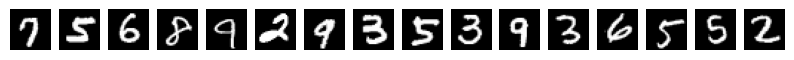

I2


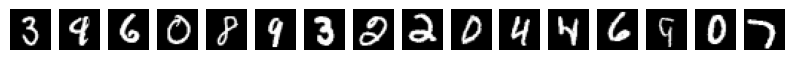

Interpolation of I1 and I2 with a = 0.9:


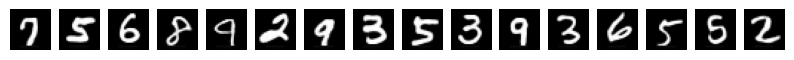

Interpolation of I1 and I2 with a = 0.7:


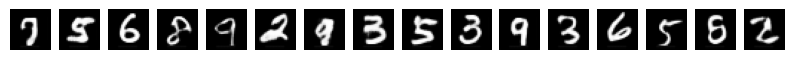

Interpolation of I1 and I2 with a = 0.5:


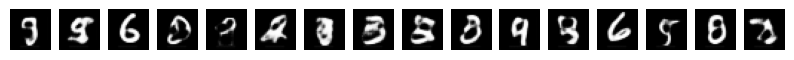

Interpolation of I1 and I2 with a = 0.3:


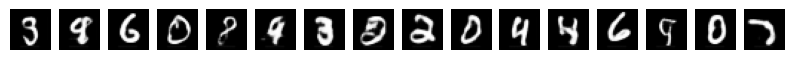

Interpolation of I1 and I2 with a = 0.1:


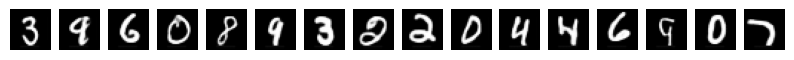

In [ ]:
i = 1
I = []
with torch.no_grad():
    for data in testloader:
        if i > 2:
            break;
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        I.append(inputs)
        # Forward pass
        i += 1

    print("I1")
    fig, axs = plt.subplots(1, I[0].shape[0], figsize=(10, 10))
    for j in range(I[0].shape[0]):
        vals = I[0][j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()

    print("I2")
    fig, axs = plt.subplots(1, I[0].shape[0], figsize=(10, 10))
    for j in range(I[1].shape[0]):
        vals = I[1][j].cpu().detach().numpy().squeeze()
        axs[j].imshow(vals, cmap='gray')
        axs[j].axis('off')
    plt.show()

    A = [0.9, 0.7, 0.5, 0.3, 0.1]   # alpha values
    for a in A:
        I1_encoded = net.encoder(I[0])
        I2_encoded = net.encoder(I[1])
        interpolated_latent_space = (I1_encoded * a) + (I2_encoded * (1-a))  # intepollation of latent vectors
        result = net.decoder(interpolated_latent_space)
        
        print(f"Interpolation of I1 and I2 with a = {a}:")
        fig, axs = plt.subplots(1, inputs.shape[0], figsize=(10, 10))
        for j in range(result.shape[0]):
            vals = result[j].cpu().detach().numpy().squeeze()
            axs[j].imshow(vals, cmap='gray')
            axs[j].axis('off')
        plt.show()

Question three - Decorrelation


In [ ]:
# nets as Q1
nets = [
    Autoencoder(2).to(device),
    Autoencoder(5).to(device),
    Autoencoder(10).to(device),
    Autoencoder(20).to(device),
    Autoencoder(784).to(device),
]
criterion = nn.BCELoss()
optimizers = [optim.Adam(net.parameters(), lr=0.001) for net in nets]
check_nets(nets)

In [ ]:
def find_pearson_correlations(net, latent_size):
    all_latent_vectors = tf.zeros((0, latent_size))
    i = 1
    # check_images_net(net)
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            cur_latent_vectors = net.encoder(inputs)
            all_latent_vectors = tf.concat([all_latent_vectors, cur_latent_vectors.cpu()], axis=0) # axis=0 means concatenate along the rows
            i += 1
    print(all_latent_vectors.shape)
    import tensorflow_probability as tfp
    pearson_corr_mat = tfp.stats.correlation(all_latent_vectors, all_latent_vectors)
    corr_value = tf.reduce_mean(tf.abs(pearson_corr_mat))
    print(corr_value)
    wandb.init(
    # Set the project where this run will be logged
    project="Encode Decoder - CNN - AE", 
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"latent space: {latent_size}", 
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.01,
    "architecture": "CNN",
    "dataset": "CIFAR-50",
    "epochs": 10,
    })
    wandb.log({"Pearson Correlation average abs": corr_value})

In [ ]:
latent_sizes = [2, 5, 10, 20, 784]
for i, net in enumerate(nets):
    find_pearson_correlations(net, latent_sizes[i])

(10000, 784)
tf.Tensor(0.13613512, shape=(), dtype=float32)


Question four - Transfer Learning

In [ ]:
# define the net as Q1
net = Autoencoder(10).to(device)  # latent space = 10
criterion = nn.BCELoss()
optimizers = [optim.Adam(net_.parameters(), lr=0.001) for net_ in [net]]
check_nets([net])

In [40]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = x.float()
        x = self.softmax(self.fc3(x))
        return x        

In [56]:
# test the model on the data set
new_test_loader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True, num_workers=2)

def record_test_loss_mlp(mlp_net, encoder):
    total_loss = 0.0
    i = 1
    # check_images_net(net)
    with torch.no_grad():
        for data in new_test_loader:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = mlp_net(encoder(inputs))
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            i += 1

    num_of_images = inputs.shape[0] * (i)  # batch size * num of batches
    average_loss = total_loss / num_of_images
    print(f'test: num_of_images: {num_of_images}, total loss: {total_loss}, test loss: {average_loss}')
    print(f"total loss: {total_loss}, num of batches: {i}")
    print('Average test set loss per batch: {:.4f}'.format(average_loss))
    return average_loss

In [67]:
### DOES NOT train the encoder parameters
mlp = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(mlp.parameters(), lr=0.001)

# detach the encoder parameters
for param in net.encoder.parameters():
    param.requires_grad = False

new_train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
for i, data in enumerate(new_train_loader):
    if i > 50:
        break
    optimizer.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)
    latent_vector = net.encoder(inputs).to(device)
    outputs = mlp(latent_vector)

    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

cur_test_loss = record_test_loss_mlp(mlp, net.encoder)
print("Test loss of MLP model without training the encoder togehter", cur_test_loss)

test: num_of_images: 10001, total loss: 21239.016813755035, test loss: 2.123689312444259
total loss: 21239.016813755035, num of batches: 10001
Average test set loss per batch: 2.1237
Test loss of MLP model without training the encoder togehter 2.123689312444259


In [68]:
### DOES train the encoder parameters
mlp2 = MLP().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam([
    {'params': mlp2.parameters()},
    {'params': net.encoder.parameters(), 'lr': 1e-3}
])

# connect the encoder parameters
for param in net.encoder.parameters():
    param.requires_grad = True

new_train_loader = torch.utils.data.DataLoader(trainset, batch_size=1, shuffle=True, num_workers=2)
for i, data in enumerate(new_train_loader):
    if i > 50:
        break
    optimizer.zero_grad()
    inputs, labels = data[0].to(device), data[1].to(device)
    latent_vector = net.encoder(inputs).to(device)
    outputs = mlp2(latent_vector)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

cur_test_loss = record_test_loss_mlp(mlp2, net.encoder)
print("Test loss of MLP model while training the encoder togehter", cur_test_loss)

test: num_of_images: 10001, total loss: 19976.841914892197, test loss: 1.9974844430449152
total loss: 19976.841914892197, num of batches: 10001
Average test set loss per batch: 1.9975
Test loss of MLP model while training the encoder togehter 1.9974844430449152
